<a href="https://colab.research.google.com/github/teja-1403/PRODIGY_ML_03/blob/main/PRODIGY_ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dogs_vs_cats_path = kagglehub.competition_download('dogs-vs-cats')

print('Data source import complete.')


 # PRODIGY_ML_03

# Classify images of cats and dogs using SVM

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [ ]:
# Extracting zip files for training and testing datasets
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

In [ ]:
# Update paths for extracted train and test directories
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

In [ ]:
# Function to load and preprocess the images
def load_images(folder, img_size=(64, 64), sample_count=None, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)

    if sample_count is not None:
        filenames = filenames[:sample_count]

    for img in tqdm(filenames, desc="Loading Images"):
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            if label_filter:
                labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

In [ ]:
# Visualize images with labels
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

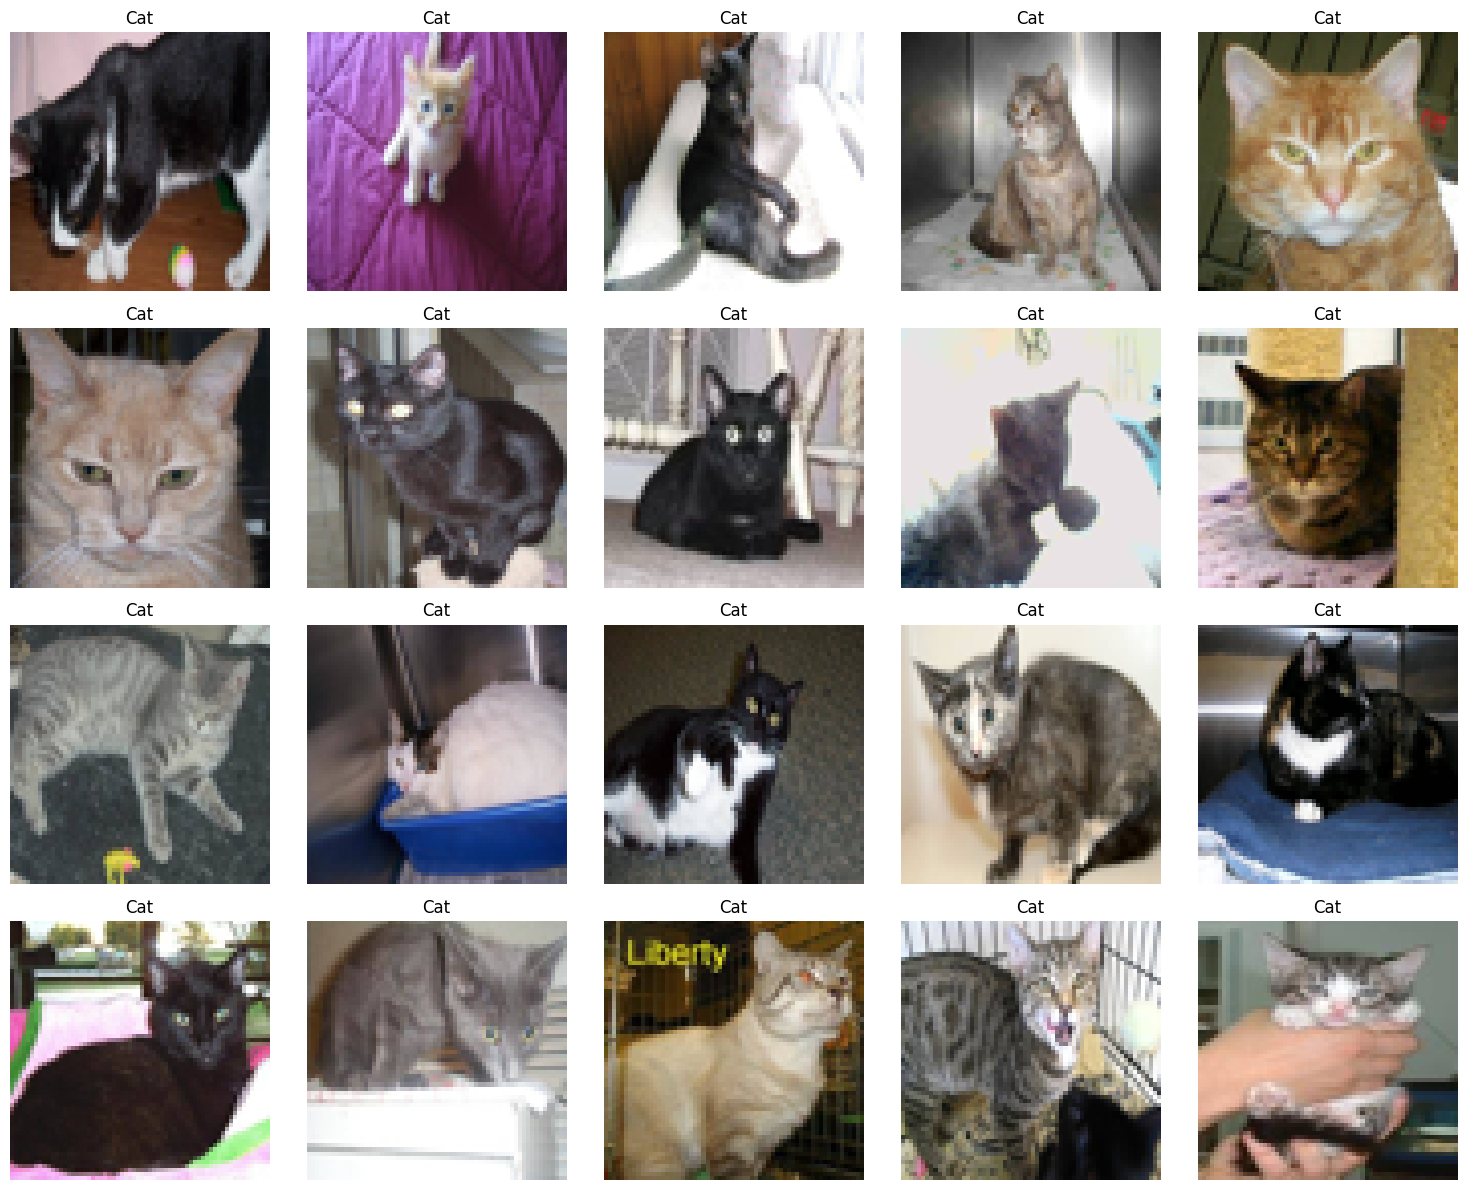

In [ ]:
# Load and visualize cat images
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

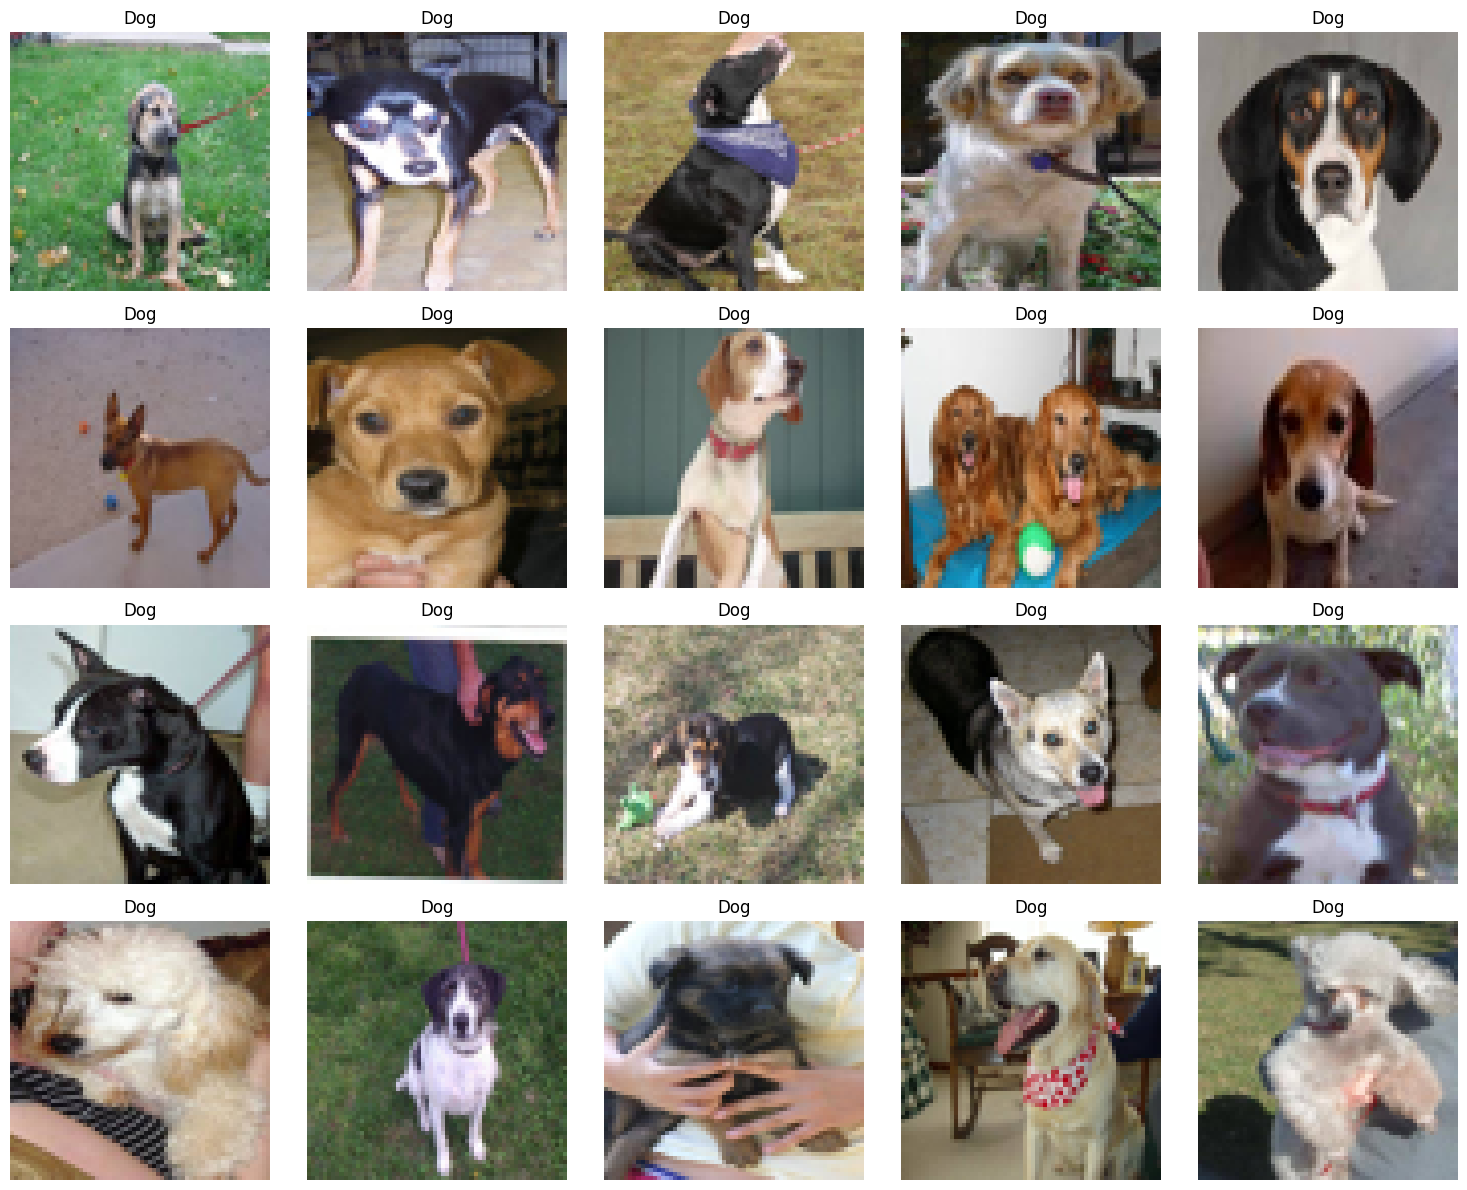

In [ ]:
# Load and visualize dog images
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

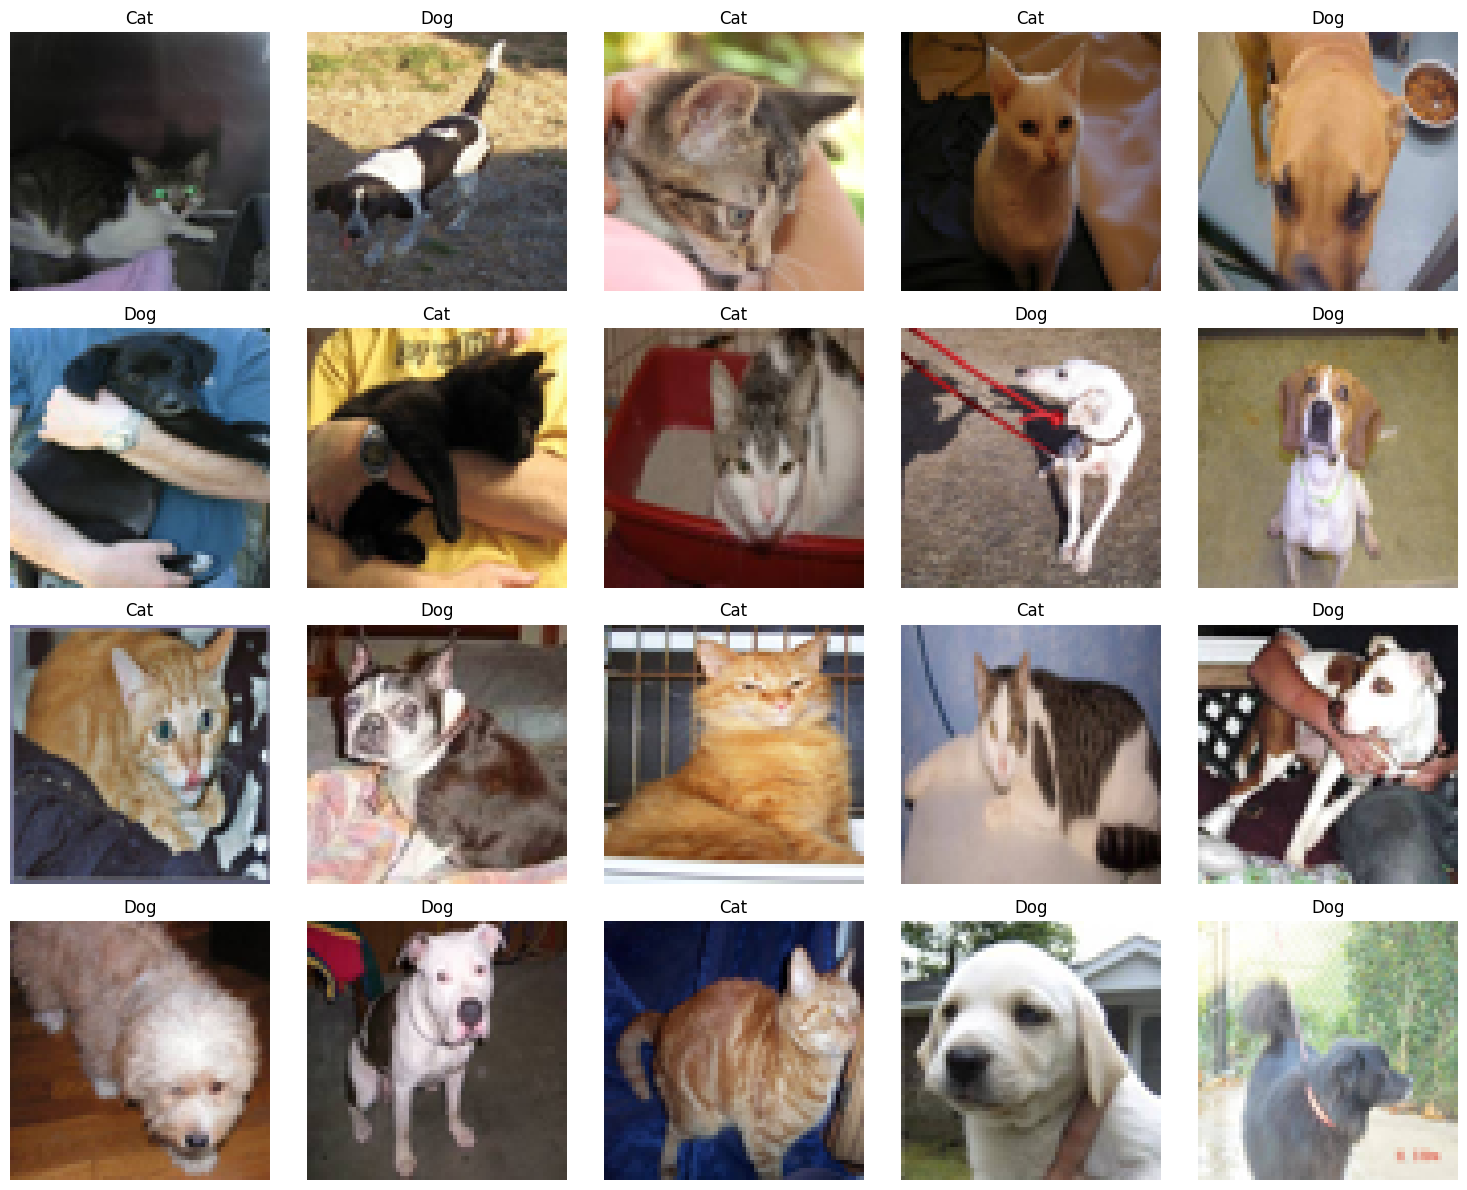

In [ ]:
# Load and visualize both cat and dog images
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

In [ ]:
# Loading and preprocessing the training data
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

In [ ]:
# Display the shape of the images array
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


In [ ]:
# Display the shape of the first image
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


In [ ]:
# Display the first 2 images
print(images[:2])
print(labels[:2])

[[[[1.90695886e-03 2.01460977e-03 2.56824298e-03]
   [2.96808920e-03 2.87581699e-03 3.07574010e-03]
   [2.95271050e-03 2.79892349e-03 2.90657439e-03]
   ...
   [8.61207228e-04 6.45905421e-04 3.07574010e-04]
   [9.68858131e-04 6.92041522e-04 4.15224913e-04]
   [7.07420223e-04 5.84390619e-04 4.61361015e-04]]

  [[1.90695886e-03 2.02998847e-03 2.58362168e-03]
   [2.99884660e-03 2.92195309e-03 3.10649750e-03]
   [2.98346790e-03 2.82968089e-03 2.93733180e-03]
   ...
   [4.61361015e-04 4.76739715e-04 6.92041522e-04]
   [5.07497116e-04 4.61361015e-04 6.76662822e-04]
   [3.69088812e-04 3.22952710e-04 4.15224913e-04]]

  [[1.93771626e-03 2.04536717e-03 2.59900038e-03]
   [3.02960400e-03 2.93733180e-03 3.13725490e-03]
   [2.99884660e-03 2.84505959e-03 2.95271050e-03]
   ...
   [1.53787005e-04 1.99923106e-04 8.91964629e-04]
   [5.07497116e-04 5.69011918e-04 1.09188774e-03]
   [1.99923106e-03 1.83006536e-03 1.83006536e-03]]

  ...

  [[2.99884660e-03 3.32179931e-03 3.58323722e-03]
   [2.81430219e-

In [ ]:
# Flattening the images for the SVM input
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

In [ ]:
# Standardizing the features
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

In [ ]:
# Splitting the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[-0.2765975 , -0.18304769,  0.13592463, ..., -1.07049216,
        -0.63597328, -0.08806265],
       [ 1.34347216,  1.36206071,  1.2975404 , ...,  0.50139055,
         0.50090867,  0.47111201],
       [-0.73537829, -1.32382866, -0.99735906, ...,  0.33827064,
         0.50090867,  0.88313544],
       ...,
       [-0.21924991,  0.06243682,  0.10759254, ...,  0.97592118,
         1.30430524,  1.47174034],
       [ 0.41157368, -0.12528663, -1.1956837 , ..., -0.50698704,
        -0.62081485, -0.94153976],
       [ 1.77357915,  1.86747   ,  1.3258725 , ..., -1.14463758,
        -1.13620133, -1.14755147]])

In [ ]:
X_val

array([[ 0.52626888,  0.64004744,  0.81589484, ..., -0.80356869,
        -0.92398337, -1.04454561],
       [ 0.51193198,  0.6544877 ,  0.66006833, ..., -0.32903806,
        -0.57533957, -0.79438853],
       [ 1.18576626,  1.10213593,  1.11338181, ..., -0.80356869,
        -1.30294402, -1.36827831],
       ...,
       [ 1.28612456,  1.57866469,  0.80172879, ..., -0.47732888,
        -0.22669578, -0.44122559],
       [-1.55258158, -1.49711184, -1.35151021, ..., -1.7081427 ,
        -1.62127096, -1.47128417],
       [-1.48089708, -1.25162733, -0.89819673, ..., -0.32903806,
        -0.60565642, -0.85324902]])

In [ ]:
X_val

array([[ 0.52626888,  0.64004744,  0.81589484, ..., -0.80356869,
        -0.92398337, -1.04454561],
       [ 0.51193198,  0.6544877 ,  0.66006833, ..., -0.32903806,
        -0.57533957, -0.79438853],
       [ 1.18576626,  1.10213593,  1.11338181, ..., -0.80356869,
        -1.30294402, -1.36827831],
       ...,
       [ 1.28612456,  1.57866469,  0.80172879, ..., -0.47732888,
        -0.22669578, -0.44122559],
       [-1.55258158, -1.49711184, -1.35151021, ..., -1.7081427 ,
        -1.62127096, -1.47128417],
       [-1.48089708, -1.25162733, -0.89819673, ..., -0.32903806,
        -0.60565642, -0.85324902]])

In [ ]:
y_val

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
# Checking class distribution
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 5012, 1: 4988}


In [ ]:
# Training the SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Making predictions on the validation set
y_val_pred = svm.predict(X_val)

In [ ]:
y_val_pred

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
# Evaluating the model
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In [ ]:
# Accuracy
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5450


In [ ]:
# Classification Report
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.55      0.57      0.56      1013
         Dog       0.54      0.52      0.53       987

    accuracy                           0.55      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.55      0.54      2000



Validation Confusion Matrix:
[[578 435]
 [475 512]]


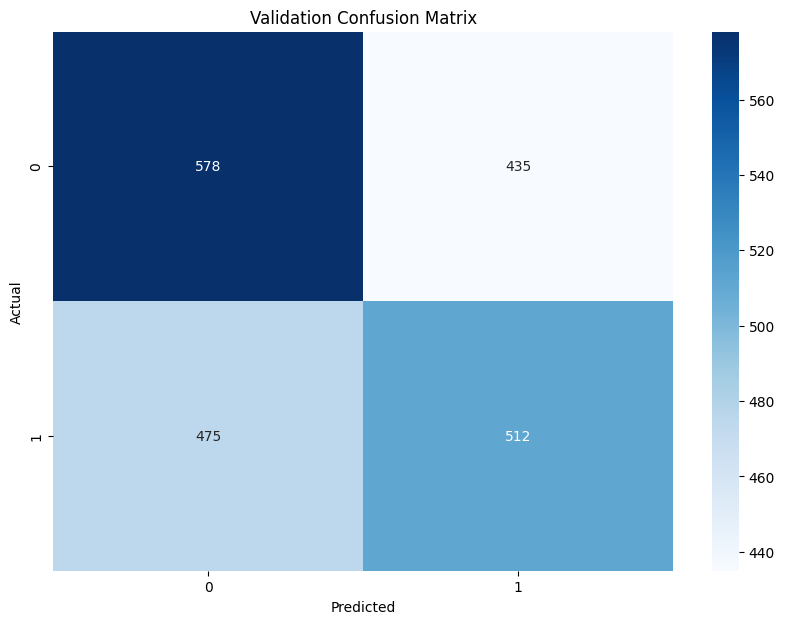

In [ ]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()


In [ ]:
# Saving the SVM model and scaler
import pickle
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# Loading and preprocessing the test data
test_images, _ = load_images(test_dir, img_size=(64, 64), sample_count=None)
test_images = test_images / 255.0

Loading Images: 100%|██████████| 12500/12500 [00:35<00:00, 351.89it/s]


In [ ]:
# Flattening the test images for the SVM input
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)

In [ ]:
# Standardizing the test features
test_images_flat_scaled = scaler.transform(test_images_flat)

In [ ]:
# Making predictions on the test set
y_test_pred = svm.predict(test_images_flat_scaled)

In [ ]:
y_test_pred

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
# Saving the test predictions to a CSV file
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [ ]:
# Confirm the number of predictions matches the test samples
print("Number of predictions:", len(test_predictions))
print(test_predictions.head())

Number of predictions: 12500
   Id Label
0   1   Cat
1   2   Dog
2   3   Dog
3   4   Cat
4   5   Cat
